# Feature Engineering with Modelling
## Author: Dulan Wijeratne 1181873

In this notebook we will make new features using modelling techniques.

First we will start by creating a Spark session and reading in the joined aggregated data.

In [1]:
from pyspark.sql import SparkSession, functions as f

In [2]:
spark = (
    SparkSession.builder.appName("feature_engineering")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '3g')   
    .config('spark.executor.memory', '4g')  
    .config('spark.executor.instances', '2')  
    .config('spark.executor.cores', '2')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
23/10/05 17:23:25 WARN Utils: Your hostname, DulanComputer resolves to a loopback address: 127.0.1.1; using 172.30.15.25 instead (on interface eth0)
23/10/05 17:23:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/05 17:23:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
joined = spark.read.parquet("../../../data/curated/removed_outliers.parquet")

In [ ]:
joined.orderBy(f.col("number_of_unique_consumers").desc()).show()

Changing NULLs to 0s

As we are going to be using modelling techniques we need to change the NULLs to an interpretable value.

In [4]:
joined = joined.fillna(0)

Next we want to convert the categorical features into integer values so that we can check its correlation between the target variables.

In the dataset there are 2 categorical features:
- Revenue Value
- Segment

In [5]:
from pyspark.ml.feature import StringIndexer

In [6]:
input_cols = ["revenue_level","segment"]
output_cols = ["revenue_level_indexed","segment_indexed"]

In [7]:
revenue_level_indexer = StringIndexer(inputCol = "revenue_level", outputCol= "revenue_level_indexed")
segment_indexer = StringIndexer(inputCol = "segment", outputCol = "segment_indexed")

In [8]:
pre_correlation_df = revenue_level_indexer.fit(joined).transform(segment_indexer.fit(joined).transform(joined))
pre_correlation_df = pre_correlation_df.drop("revenue_level", "segment","name","first_recorded_transaction","last_recorded_transaction")

In [9]:
correlation_df = pre_correlation_df.toPandas()

Now we will check the correlation matrix

In [10]:
import pandas as pd

In [11]:
correlation_df.head()

,merchant_abn,take_rate,average_merchant_fraud_probability,number_of_unique_consumers,average_consumer_fraud_probability,number_of_repeat_consumers,average_repeat_transactions_per_consumer,number_of_orders,average_cost_of_order,average_spend_per_consumer,...,number_of_postcodes,avg_total_weekly_personal_income,avg_total_weekly_fam_income,avg_median_age,avg_household_size,postcode_reach,avg_num_of_consumers_per_postcode,bnpl_maximum_gain,segment_indexed,revenue_level_indexed
0,16550028284,6.52,0.0,103,0.084383,1,1.009709,104,206.620211,208.626233,...,101,821.355769,2081.072115,43.033654,2.456731,0.038272,1.029703,1401.050196,2.0,0.0
1,21437482304,5.71,0.0,47,0.000000,0,1.000000,47,310.808283,310.808283,...,47,750.159574,1876.946809,43.542553,2.435106,0.017810,1.000000,834.116235,1.0,0.0
2,68535898735,2.87,0.0,19,2.068235,0,1.000000,19,3406.956557,3406.956557,...,19,768.394737,1863.921053,42.500000,2.512632,0.007200,1.000000,1857.813205,3.0,2.0
3,27440079026,2.53,0.0,1156,0.067623,34,1.029412,1190,451.566416,464.847781,...,947,794.315546,1965.475210,43.044118,2.463672,0.358848,1.256600,13595.309805,0.0,2.0
4,53062283717,3.93,0.0,3180,0.056882,288,1.094340,3480,404.681587,442.859096,...,1869,789.271839,1973.562931,42.969971,2.460109,0.708223,1.861958,55345.873396,0.0,1.0


In [12]:
corr_matrix = correlation_df.corr()

We will matrix a heat map of the correlation matrix to view the correlations more visually.

In [ ]:
import seaborn as sns
sns.heatmap(corr_matrix)

### Feature Engineering

Predicting number of consumers in 3 years

In [13]:
corr_matrix.loc["number_of_unique_consumers"]

merchant_abn                                0.004690
take_rate                                   0.039364
average_merchant_fraud_probability         -0.005603
number_of_unique_consumers                  1.000000
average_consumer_fraud_probability         -0.144273
number_of_repeat_consumers                  0.860697
average_repeat_transactions_per_consumer    0.613602
number_of_orders                            0.714180
average_cost_of_order                      -0.180890
average_spend_per_consumer                 -0.171051
average_monthly_diff_consumers              0.773080
consumer_diff_over_period                   0.773120
average_growth_consumers                    0.442527
merchant_revenue_rounded                    0.647470
transcation_period_months                   0.243275
number_of_postcodes                         0.845176
avg_total_weekly_personal_income            0.008346
avg_total_weekly_fam_income                 0.010363
avg_median_age                             -0.

Next we seperate the features and the target variables

In [14]:
modelling_df = correlation_df.copy()

In [15]:
modelling_df.head()

,merchant_abn,take_rate,average_merchant_fraud_probability,number_of_unique_consumers,average_consumer_fraud_probability,number_of_repeat_consumers,average_repeat_transactions_per_consumer,number_of_orders,average_cost_of_order,average_spend_per_consumer,...,number_of_postcodes,avg_total_weekly_personal_income,avg_total_weekly_fam_income,avg_median_age,avg_household_size,postcode_reach,avg_num_of_consumers_per_postcode,bnpl_maximum_gain,segment_indexed,revenue_level_indexed
0,16550028284,6.52,0.0,103,0.084383,1,1.009709,104,206.620211,208.626233,...,101,821.355769,2081.072115,43.033654,2.456731,0.038272,1.029703,1401.050196,2.0,0.0
1,21437482304,5.71,0.0,47,0.000000,0,1.000000,47,310.808283,310.808283,...,47,750.159574,1876.946809,43.542553,2.435106,0.017810,1.000000,834.116235,1.0,0.0
2,68535898735,2.87,0.0,19,2.068235,0,1.000000,19,3406.956557,3406.956557,...,19,768.394737,1863.921053,42.500000,2.512632,0.007200,1.000000,1857.813205,3.0,2.0
3,27440079026,2.53,0.0,1156,0.067623,34,1.029412,1190,451.566416,464.847781,...,947,794.315546,1965.475210,43.044118,2.463672,0.358848,1.256600,13595.309805,0.0,2.0
4,53062283717,3.93,0.0,3180,0.056882,288,1.094340,3480,404.681587,442.859096,...,1869,789.271839,1973.562931,42.969971,2.460109,0.708223,1.861958,55345.873396,0.0,1.0


In [16]:
target_variable = "number_of_unique_consumers"

In [17]:
features_unique_customers = modelling_df.drop(columns = ["merchant_abn",target_variable])
number_of_unique_customer = modelling_df[target_variable]

Feature Selection

In [18]:
from sklearn.feature_selection import f_regression, SelectKBest

In [19]:
selector = SelectKBest(score_func=f_regression, k= 5)
features_unique_customers_selected = selector.fit_transform(features_unique_customers, number_of_unique_customer)

In [20]:
selected_feature_indices = selector.get_support(indices=True)
selected_features = features_unique_customers.columns[selected_feature_indices]
print(selected_features)

Index(['number_of_repeat_consumers', 'average_monthly_diff_consumers',
       'consumer_diff_over_period', 'number_of_postcodes', 'postcode_reach'],
      dtype='object')


In [21]:
# add transaction period features as this feature will be changed
selected_features = selected_features.append(pd.Index(['transcation_period_months']))
print(selected_features)

Index(['number_of_repeat_consumers', 'average_monthly_diff_consumers',
       'consumer_diff_over_period', 'number_of_postcodes', 'postcode_reach',
       'transcation_period_months'],
      dtype='object')


Splitting the data for train and test 
 - We will use a 80 - 20

In [22]:
from sklearn.model_selection import train_test_split

In [55]:
features_unique_customers_train, features_unique_customers_test, number_of_unique_customer_train, number_of_unique_customer_test = \
    train_test_split(features_unique_customers[selected_features], number_of_unique_customer, test_size=0.2, random_state=42)

### Fitting the model

First we will fit a linear regression model

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [57]:
num_of_unique_customers_model_LR = LinearRegression()
num_of_unique_customers_model_LR.fit((features_unique_customers_train), (number_of_unique_customer_train))

LinearRegression()

Linear Regression Model Evaluation

In [58]:
num_of_unique_customer_pred_LR = num_of_unique_customers_model_LR.predict(features_unique_customers_test)
mse = mean_squared_error((number_of_unique_customer_test), (num_of_unique_customer_pred_LR))
rmse = (mse ** 0.5)
r2 = r2_score((number_of_unique_customer_test), num_of_unique_customer_pred_LR)

In [59]:
print(f'R-squared (R2): {r2}')
print(f"RMSE: {rmse}")

R-squared (R2): 0.9678928618330703
RMSE: 543.9725858257284


In [60]:
residuals = (number_of_unique_customer_test) - num_of_unique_customer_pred_LR

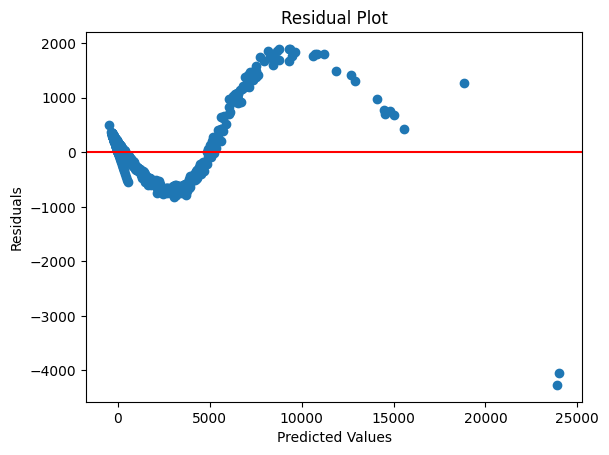

In [61]:
plt.scatter(num_of_unique_customer_pred_LR, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

By looking at the residual plot we can see that the underlying distribution is non-linear, so we will fit a Random Forest Regressor model.

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [31]:
num_of_unique_customers_model_RFR = RandomForestRegressor()
num_of_unique_customers_model_RFR.fit((features_unique_customers_train), np.log(number_of_unique_customer_train))

RandomForestRegressor()

Random Forest Regressor Evaluation

In [32]:
num_of_unique_customer_pred_RFR = num_of_unique_customers_model_RFR.predict(features_unique_customers_test)
mse = mean_squared_error(np.log(number_of_unique_customer_test), (num_of_unique_customer_pred_RFR))
rmse = (mse ** 0.5)
r2 = r2_score(np.log(number_of_unique_customer_test), num_of_unique_customer_pred_RFR)

In [33]:
print(f'R-squared (R2): {r2}')
print(f"RMSE: {rmse}")

R-squared (R2): 0.9999448716433045
RMSE: 0.014972297107788324


In [34]:
residuals = np.log(number_of_unique_customer_test) - num_of_unique_customer_pred_RFR

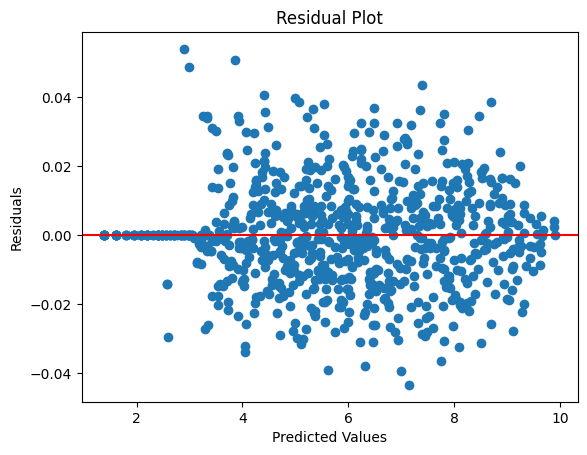

In [35]:
import matplotlib.pyplot as plt
plt.scatter(num_of_unique_customer_pred_RFR, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

We will also use a XGBoost model

In [36]:
from xgboost import XGBRegressor

In [37]:
num_of_unique_customers_model_XGB = XGBRegressor()
num_of_unique_customers_model_XGB.fit((features_unique_customers_train), np.log(number_of_unique_customer_train))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
num_of_unique_customer_pred_XGB = num_of_unique_customers_model_XGB.predict(features_unique_customers_test)
mse = mean_squared_error(np.log(number_of_unique_customer_test), (num_of_unique_customer_pred_XGB))
rmse = (mse ** 0.5)
r2 = r2_score(np.log(number_of_unique_customer_test), num_of_unique_customer_pred_XGB)

In [39]:
print(f'R-squared (R2): {r2}')
print(f"RMSE: {rmse}")

R-squared (R2): 0.999831815918496
RMSE: 0.026151304467113175


In [40]:
residuals = np.log(number_of_unique_customer_test) - num_of_unique_customer_pred_XGB

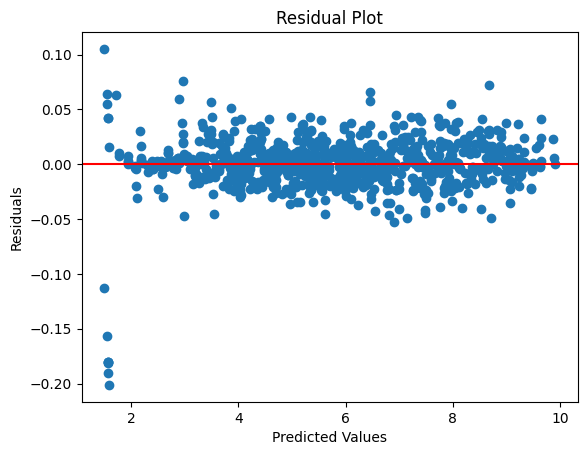

In [41]:
import matplotlib.pyplot as plt
plt.scatter(num_of_unique_customer_pred_XGB, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

Next we will predict the number of customers in 3 years

In [62]:
future_modelling_df = modelling_df.copy()
future_modelling_df = future_modelling_df.sort_values(by='merchant_abn')

In [63]:
future_modelling_df["transcation_period_months"] = future_modelling_df["transcation_period_months"] + 36

In [44]:
future_modelling_df.head()

,merchant_abn,take_rate,average_merchant_fraud_probability,number_of_unique_consumers,average_consumer_fraud_probability,number_of_repeat_consumers,average_repeat_transactions_per_consumer,number_of_orders,average_cost_of_order,average_spend_per_consumer,...,number_of_postcodes,avg_total_weekly_personal_income,avg_total_weekly_fam_income,avg_median_age,avg_household_size,postcode_reach,avg_num_of_consumers_per_postcode,bnpl_maximum_gain,segment_indexed,revenue_level_indexed
1095,10023283211,0.18,0.0,2525,0.095502,174,1.071683,2706,215.797947,231.267028,...,1628,786.702328,1971.123799,43.031966,2.456914,0.616900,1.662162,1051.108692,2.0,4.0
2050,10142254217,4.22,0.0,2389,0.064356,151,1.064881,2544,38.591470,41.095311,...,1591,792.250000,1983.427083,42.850629,2.464025,0.602880,1.598994,4143.056534,1.0,1.0
3961,10165489824,4.40,0.0,4,6.979429,0,1.000000,4,8885.894209,8885.894209,...,4,817.500000,2066.125000,41.625000,2.475000,0.001516,1.000000,1563.917554,4.0,1.0
928,10187291046,3.29,0.0,291,0.058022,1,1.003436,292,115.995570,116.394180,...,273,796.547945,1961.171233,43.125000,2.449418,0.103448,1.069597,1114.346346,4.0,1.0
2236,10192359162,6.33,0.0,321,0.036126,2,1.006231,323,460.347109,463.215315,...,303,808.877709,2024.267802,43.294118,2.445480,0.114816,1.066007,9412.211083,0.0,0.0


In [64]:
future_features_unique_customers = future_modelling_df.drop(columns = ["merchant_abn",target_variable])

In [65]:
future_features_unique_customers.columns

Index(['take_rate', 'average_merchant_fraud_probability',
       'average_consumer_fraud_probability', 'number_of_repeat_consumers',
       'average_repeat_transactions_per_consumer', 'number_of_orders',
       'average_cost_of_order', 'average_spend_per_consumer',
       'average_monthly_diff_consumers', 'consumer_diff_over_period',
       'average_growth_consumers', 'merchant_revenue_rounded',
       'transcation_period_months', 'number_of_postcodes',
       'avg_total_weekly_personal_income', 'avg_total_weekly_fam_income',
       'avg_median_age', 'avg_household_size', 'postcode_reach',
       'avg_num_of_consumers_per_postcode', 'bnpl_maximum_gain',
       'segment_indexed', 'revenue_level_indexed'],
      dtype='object')

In [66]:
future_features_unique_customers[selected_features]

,number_of_repeat_consumers,average_monthly_diff_consumers,consumer_diff_over_period,number_of_postcodes,postcode_reach,transcation_period_months
1095,174,7.750000,155,1628,0.616900,55.677419
2050,151,9.150000,183,1591,0.602880,55.322581
3961,0,0.000000,0,4,0.001516,42.903226
928,1,0.315789,6,273,0.103448,54.677419
2236,2,0.736842,14,303,0.114816,54.741935
...,...,...,...,...,...,...
877,3315,35.600000,712,2594,0.982948,55.451613
1822,0,0.166667,3,103,0.039030,55.096774
2723,5087,49.350000,987,2623,0.993937,55.354839
2657,1,0.210526,4,145,0.054945,54.838710


In [67]:
predicted_num_of_unique_customers_LR= num_of_unique_customers_model_LR.predict(future_features_unique_customers[selected_features])
predicted_num_of_unique_customers_RFR= num_of_unique_customers_model_RFR.predict(future_features_unique_customers[selected_features])
predicted_num_of_unique_customers_XGB= num_of_unique_customers_model_XGB.predict(future_features_unique_customers[selected_features])

In [68]:
results = future_modelling_df.copy()
results["predicted_num_of_unique_customers_LR"] = (predicted_num_of_unique_customers_LR)
results["predicted_num_of_unique_customers_RFR"] = np.exp(predicted_num_of_unique_customers_RFR)
results["predicted_num_of_unique_customers_XGB"] = np.exp(predicted_num_of_unique_customers_XGB)

In [69]:
results_df = spark.createDataFrame(results)

In [70]:
results_df_LR = results_df.select(f.col("merchant_abn"),f.col("predicted_num_of_unique_customers_LR"))
results_df_RFR = results_df.select(f.col("merchant_abn"),f.col("predicted_num_of_unique_customers_RFR"))
results_df_XGB = results_df.select(f.col("merchant_abn"),f.col("predicted_num_of_unique_customers_XGB"))

In [71]:
joined_LR = joined.join(results_df_LR, on = "merchant_abn", how = "inner")
joined_RFR = joined.join(results_df_RFR, on = "merchant_abn", how = "inner")
joined_XGB = joined.join(results_df_XGB, on = "merchant_abn", how = "inner")

In [72]:
joined_LR = joined_LR.withColumn("predicted_num_of_unique_customers", f.when(joined_LR.predicted_num_of_unique_customers_LR < 0, 0).otherwise(f.round(joined_LR.predicted_num_of_unique_customers_LR)))
joined_RFR = joined_RFR.withColumn("predicted_num_of_unique_customers", f.when(joined_RFR.predicted_num_of_unique_customers_RFR < 0, 0).otherwise(f.round(joined_RFR.predicted_num_of_unique_customers_RFR)))
joined_XGB = joined_XGB.withColumn("predicted_num_of_unique_customers", f.when(joined_XGB.predicted_num_of_unique_customers_XGB < 0, 0).otherwise(f.round(joined_XGB.predicted_num_of_unique_customers_XGB)))

In [73]:
joined_LR.orderBy(f.col("predicted_num_of_unique_customers").desc()).show()

+------------+--------------------+-------------+------------------+----------------------------------+--------------------------+----------------------------------+--------------------------+----------------------------------------+----------------+---------------------+--------------------------+------------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+-------------------------+-------------------+--------------------------------+---------------------------+------------------+------------------+------------------+---------------------------------+--------------------+------------------+------------------------------------+---------------------------------+
|merchant_abn|                name|revenue_level|         take_rate|average_merchant_fraud_probability|number_of_unique_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|average_repeat_transactions_per_consume

In [ ]:
joined_LR.write.mode("overwrite").parquet("../../../data/ranking_data_LR.parquet")
joined_RFR.write.mode("overwrite").parquet("../../../data/ranking_data_RFR.parquet")
joined_XGB.write.mode("overwrite").parquet("../../../data/ranking_data_XGB.parquet")

In [ ]:
spark.stop()

### Summary
In this notebook we aimed to find the number of consumers a merchant would have in 3 years. To achieve this we did the following:
- We checked the correlation between the number of customers and other features.
- We performed feature selection based on statistical tests.
- Split the data into test and training.
- Fitted 3 models to the data and determined which model performed the best by viewing residual vs fitted values graphs, R-Squared value and the RSME value.
- Identified XGBoost Regression model performed the best.
- Created new modelled feature for the number of customers in 3 years using the XGBoost Regression model.  